In [1]:
import os
import matplotlib.pyplot as plt
import shutil
import numpy as np
from PIL import Image
import h5py
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import softmax
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, losses
from tensorflow.keras import initializers
from tensorflow.keras import callbacks

import numpy.random as nr
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
import sklearn.metrics as sklm
from sklearn import preprocessing
from sklearn import linear_model
import scipy.stats as ss
import seaborn as sns
import math
import pandas as pd
import gc


In [2]:
directory = './dataset/segmented_data_ready/'
batch_size=8

train_data = tf.keras.utils.image_dataset_from_directory(
    directory,
validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(224, 224),
  batch_size=batch_size
)


val_data = tf.keras.utils.image_dataset_from_directory(
  directory,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(224, 224),
  batch_size=batch_size
)


Found 1196 files belonging to 2 classes.
Using 957 files for training.
Found 1196 files belonging to 2 classes.
Using 239 files for validation.


In [3]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_data = train_data.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_data = val_data.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [4]:
with tf.device('/CPU:0'):
    vgg16_model = VGG16(weights='imagenet', input_shape=(224, 224, 3), include_top=True)

    # Freeze all layers expect last four layers
    for layer in vgg16_model.layers:
        if layer.name == 'block5_conv1':
            break
        else:
            layer.trainable = False

    # ---------Create Reference Model------------
    # g(.) feature extraction network
    input_layer = vgg16_model.input
    x = vgg16_model.layers[-2].output
    x = Dense(1000, activation='relu')(x)
    x = Dense(100, activation = 'relu')(x)
    x = Dense(10, activation='relu')(x)
#      latent space
    embadding_layer = Dense(2, activation='relu')(x)
    classification_layer = Dense(2, activation='softmax')(embadding_layer)
    model = Model(inputs=input_layer, outputs=classification_layer)
    
print('Number of trainable layers: ', len(model.trainable_weights))
print('Number of non trainable layers: ', len(model.non_trainable_weights))
print(model.summary())

Number of trainable layers:  20
Number of non trainable layers:  20
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [6]:
epochs=2
# batch_size = 32
learning_rate = 0.0001
decay = 0.005
momentum1=0.9
momentum2=0.999

with tf.device('/CPU:0'):
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=learning_rate,
        beta_1=momentum1,
        beta_2=momentum1,
        epsilon=1e-07,
        amsgrad=False,
        name="Adam",
        # decay=decay
    )

    early_stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=5)


    metrics_pr_re = [
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall'),
          tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
          ]


    model.compile(
          optimizer = optimizer, 
          loss = losses.SparseCategoricalCrossentropy(),
          metrics = 'accuracy'
          )

In [7]:
from tensorflow.keras.callbacks import LearningRateScheduler
history=model.fit(
    train_data,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    # callbacks=[LearningRateScheduler(lr_schedule,verbose=1)],
    validation_split=None,
    validation_data=val_data,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
)

Epoch 1/2
120/120 [==============================] - 924s 8s/step - loss: 0.1395 - accuracy: 0.9457 - val_loss: 0.0134 - val_accuracy: 1.0000
Epoch 2/2
120/120 [==============================] - 726s 6s/step - loss: 0.0103 - accuracy: 0.9969 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


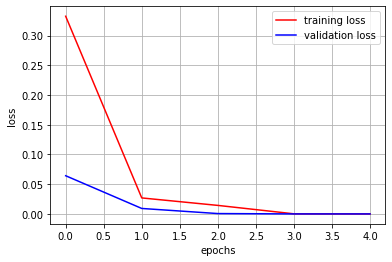

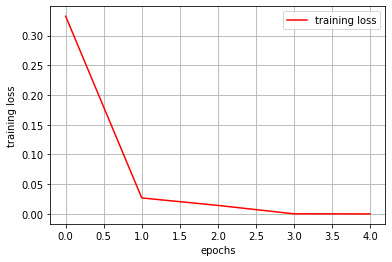

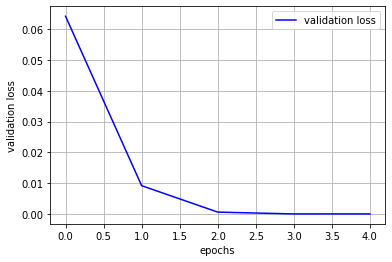

In [7]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], color='red', label='training loss')
plt.plot(history.history["val_loss"], color='blue', label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='best')
plt.grid()
plt.show()

plt.plot(history.history["loss"], color='red', label='training loss')
#plt.plot(range(0,epochs), history.history["val_loss"], color='blue', label='validation loss')
plt.xlabel('epochs')
plt.ylabel('training loss')
plt.legend(loc='best')
plt.grid()
plt.show()

#plt.plot(range(0,epochs), history.history["loss"], color='grey', label='training loss')
plt.plot(history.history["val_loss"], color='blue', label='validation loss')
plt.xlabel('epochs')
plt.ylabel('validation loss')
plt.legend(loc='best')
plt.grid()
plt.show()

In [8]:
save_path = 'Similarity_measure'
model.save(save_path)

# autoencoder.save_weights(save_path, save_format='tf')

INFO:tensorflow:Assets written to: Similarity_measure\assets


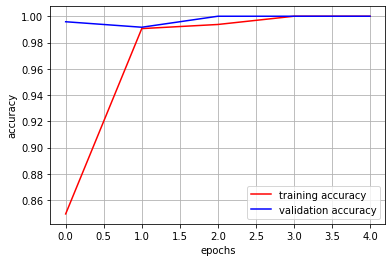

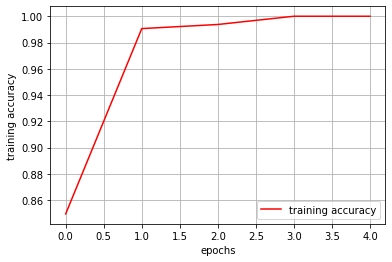

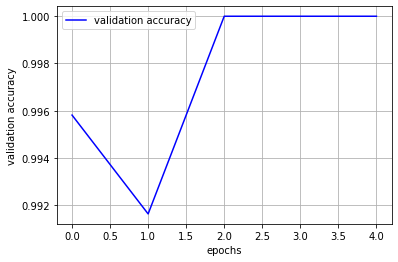

In [9]:
plt.plot(history.history["accuracy"], color='red', label='training accuracy')
plt.plot(history.history["val_accuracy"], color='blue', label='validation accuracy')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

plt.plot(history.history["accuracy"], color='red', label='training accuracy')
plt.xlabel('epochs')
plt.ylabel('training accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

plt.plot(history.history["val_accuracy"], color='blue', label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('validation accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

In [1]:
save_path = 'Similarity_measure'
model = tf.keras.models.load_model(save_path)

NameError: name 'tf' is not defined

In [3]:
feature_extraction_model = Model(inputs = model.input, outputs = model.layers[-2].output)

In [4]:
feature_extraction_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
CT_folder = 'D:\AI\code\Azure_notebook_data\medical images predictions\dataset\segmented_data_ready\CT_BH'
DynaCT_folder = 'D:\AI\code\Azure_notebook_data\medical images predictions\dataset\segmented_data_ready\DynaCT_BH'
CT_data = tf.keras.utils.image_dataset_from_directory(
  CT_folder,
  image_size=(224, 224),
)

DynaCT_data = tf.keras.utils.image_dataset_from_directory(
  DynaCT_folder,
  image_size=(224, 224),
)

Found 699 files belonging to 1 classes.
Found 497 files belonging to 1 classes.


In [6]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
CT_data = CT_data.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
DynaCT_data = DynaCT_data.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [7]:
CT_features = feature_extraction_model.predict(CT_data)
DynaCT_features = feature_extraction_model.predict(DynaCT_data)

In [8]:
CT_features_s = np.sort(CT_features, axis=0)
DynaCT_features_s = np.sort(DynaCT_features, axis=0)

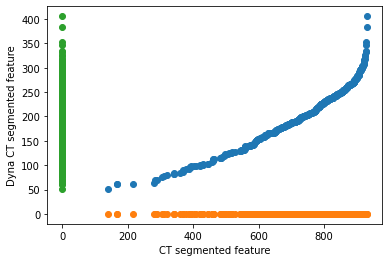

In [89]:
plt.scatter(CT_features_s[:497,0],DynaCT_features_s[:,1])
plt.scatter(CT_features_s[:497,0],CT_features_s[:497,1])
plt.scatter(DynaCT_features[:,0],DynaCT_features[:,1])
plt.xlabel('CT segmented feature')
plt.ylabel('Dyna CT segmented feature')
plt.show()